Probing the Limits of Domain Adaptation
---
##### Author: [Sneh Pandya](https://snehjp2.github.io)

In the last tutorial, we saw an instance of distance-based and adversarial domain adaptation (DA) techniques working to improve the generalization of a NN trained on MNIST and evaluated on MNIST-M. We will now move to a more physical dataset of galaxy morphologies, with the differences between source and target domain due to fundamentally different imaging devices. We will be using the Sinkhorn divergence as our distance metric for DA.

<img src="https://snehjp2.github.io/images/gaussian_meme.png" alt="gaussian meme" width="600"/>


The particular focus here will be playing around with hyperparameters, illustrating the success and failure points of DA and the importance of finding the right sweet-spot for training. We will end with more sophisticated techniques for implementing DA that can automate-away the need for hyperparameter tuning. To that end we will again consider a subset of the full galaxy dataset to simplify the task. We'll start with the same code imports as before:

In [1]:
# torch related imports
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder

import copy

# miscellaneous
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Callable, Optional
import os
import random
import urllib
import zipfile

# geomloss provides distance measure that are torch/CUDA compatible.
# uncomment line below to install it, if you don't have it installed.

!pip install -q geomloss

from geomloss import SamplesLoss

def set_all_seeds(seed=42):

    os.environ["PYTHONHASHSEED"] = str(seed)  # For Python's hash seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: enforce deterministic algorithms where possible
    torch.use_deterministic_algorithms(True, warn_only=True)

set_all_seeds()


Problem Setup
---

Our problem setup follows similarly from Tutorial 1. We will be using [GeomLoss package](https://www.kernel-operations.io/geomloss/api/pytorch-api.html) to implement MMD and Optimal transport (via Sinkhorn algorithm).

- **Neural Network**:  
Let $f_\theta$ denote a neural network classifier with parameters $\theta$, which maps an input image $x \in \mathbb{R}^n$ to predicted class probabilities $\hat{y} = f_\theta(x) \in \mathbb{R}^K$. The network is decomposed into a feature extractor $\phi_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^d$ and a classifier head $g_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^K$, such that $f_\theta(x) = \text{softmax}(g_\theta(\phi_\theta(x)))$.  
We define the **latent representation** $z = \phi_\theta(x)$ as the output of the final hidden layer (before the logits). This representation (also called the *latent vector* or *latent space*) will be used for domain alignment.

- **Source domain dataset**:  
$\mathcal{D}_s = \{(x_s^{(i)}, y_s^{(i)})\}_{i=1}^{N_s}$,  
where $x_s^{(i)} \sim p_s(x)$ are grayscale digit images from MNIST, and $y_s^{(i)} \in \{1, 4, 8 \}$ are the corresponding digit labels.

- **Target domain dataset**:  
$\mathcal{D}_t = \{x_t^{(j)}\}_{j=1}^{N_t}$,  
where $x_t^{(j)} \sim p_t(x)$ are unlabeled images from MNIST-M.  
We assume the label distributions are aligned, i.e., $p_s(y|x) = p_t(y|x)$, but the input distributions differ: $p_s(x) \neq p_t(x)$.  
Our goal is to adapt $f_\theta$ using **only labeled source data** and **unlabeled target data**, so that it performs well on the target domain.

- **Classification loss**:  
On the source domain, we minimize the supervised cross-entropy loss between predicted and true labels:

$$
\mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(y_s^{(i)})}(x_s^{(i)}),
$$

where $f_\theta^{(k)}(x)$ denotes the predicted probability for class $k$. We proceed similarly to the previous tutorial and consider a subset of the data, so we set $K = 4$ as the number of classes.

---
Let's start by defining our necessary ingredients, starting with the data. MNIST ($\mathcal{D}_s$) is readily available from `torchvision`, but we'll have to download MNIST-M ($\mathcal{D}_t$) from source. MNIST is single channel and MNISTM is three channel; we'll copy the single channel image across three channels so that the images can be loaded into the model properly. We will limit ourselves to a subset for the data so that you can train things rather quickly.

Recall that images are typically normalized to be in the range [-1,1] for gradient stabilitiy during training. This is done via [z-score normalization](https://en.wikipedia.org/wiki/Standard_score). I've precalculated the means and standard deviations of the datasets for you. Feel free to check this yourself! This is an often not-discussed/overlooked aspect of training NNs, but data normalization is **immensely important**. Lets start by defining our dataset class:


In [2]:
mnist_mean = (0.1307,) * 3 ## found online
mnist_std = (0.3015,) * 3 ## found online

mnistm_mean = (0.4579, 0.4621, 0.4082) #I've precalculated these
mnistm_std = (0.1880, 0.1755, 0.1956) #I've precalculated these

In [3]:
# Define target digits
target_digits = [1, 4, 8]

# Define transform
mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

# Load full MNIST datasets
mnist_train_full = MNIST(root='../data', train=True, download=True, transform=mnist_transform)
mnist_test_full = MNIST(root='../data', train=False, download=True, transform=mnist_transform)

# Filter indices for only digits 1, 4, 8
def filter_indices(dataset, allowed_labels):
    return [i for i, (_, label) in enumerate(dataset) if label in allowed_labels]

filtered_train_indices = filter_indices(mnist_train_full, target_digits)
filtered_test_indices = filter_indices(mnist_test_full, target_digits)

# Create subsets for training and testing
train_subset_size = 5000
test_subset_size = 1000

train_indices = torch.tensor(filtered_train_indices)[torch.randperm(len(filtered_train_indices))[:train_subset_size]]
test_indices = torch.tensor(filtered_test_indices)[torch.randperm(len(filtered_test_indices))[:test_subset_size]]

mnist_train = Subset(mnist_train_full, train_indices)
mnist_test = Subset(mnist_test_full, test_indices)

# Define DataLoaders
source_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
source_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)



## Downloading MNIST-M and defining data loaders. MNIST-M labels are included but will not be used during training.

url = "https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip"
zip_path = "../data/MNIST-M.zip"
extract_path = "../data/mnist_m"

if not os.path.exists(zip_path):
    print("Downloading MNIST‑M dataset...")
    urllib.request.urlretrieve(url, zip_path)

if not os.path.exists(extract_path):
    print("Extracting MNIST‑M...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

print("Files extracted to", extract_path)

Files extracted to ../data/mnist_m


In [4]:
# Transform for MNIST-M
mnistm_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mnistm_mean, mnistm_std)
])

# Load full MNIST-M dataset
mnistm_train_full = ImageFolder(root=os.path.join(extract_path, "MNIST-M/training"), transform=mnistm_transform)
mnistm_test_full = ImageFolder(root=os.path.join(extract_path, "MNIST-M/testing"), transform=mnistm_transform)

# Filter indices to only keep labels 1, 4, 8
def filter_indices(dataset, allowed_labels):
    return [i for i, (_, label) in enumerate(dataset) if label in allowed_labels]

filtered_train_indices = filter_indices(mnistm_train_full, target_digits)
filtered_test_indices = filter_indices(mnistm_test_full, target_digits)

# Create subsets for training and testing
train_indices = torch.tensor(filtered_train_indices)[torch.randperm(len(filtered_train_indices))[:train_subset_size]]
test_indices = torch.tensor(filtered_test_indices)[torch.randperm(len(filtered_test_indices))[:test_subset_size]]

# Create subset datasets
mnistm_train = Subset(mnistm_train_full, train_indices)
mnistm_test = Subset(mnistm_test_full, test_indices)

# Define DataLoaders
target_train_loader = DataLoader(mnistm_train, batch_size=64, shuffle=True)
target_test_loader = DataLoader(mnistm_test, batch_size=64, shuffle=False)

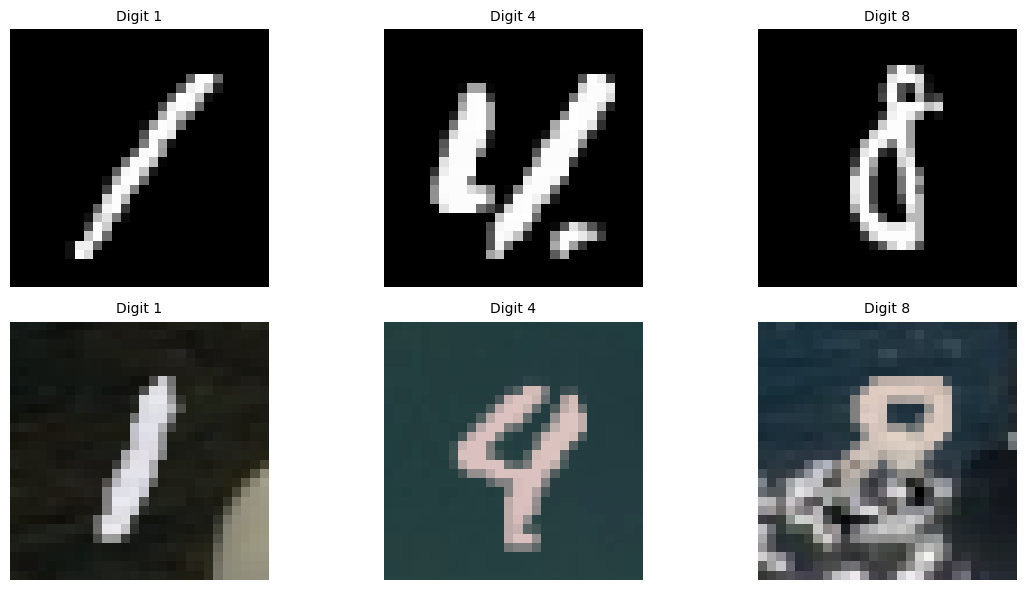

In [5]:
# Collect one example per digit
def get_examples_by_label(dataset, target_digits):
    label_to_img = {}
    for img, label in dataset:

        label = int(label)
        if label in target_digits and label not in label_to_img:
            label_to_img[label] = img
        if len(label_to_img) == len(target_digits):
            break
    return label_to_img

def unnormalize(img, mean, std):
    img = img.clone()
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return img

# Get one image per digit
mnist_digits = get_examples_by_label(mnist_train, target_digits)
mnistm_digits = get_examples_by_label(mnistm_train, target_digits)

# Plot the images
fig, axes = plt.subplots(2, len(target_digits), figsize=(12, 6))

for idx, digit in enumerate(target_digits):
    img_mnist = unnormalize(mnist_digits[digit], mnist_mean, mnist_std)
    axes[0, idx].imshow(img_mnist.permute(1, 2, 0).numpy())
    axes[0, idx].set_title(f"Digit {digit}", fontsize=10)
    axes[0, idx].axis("off")

    img_mnistm = unnormalize(mnistm_digits[digit], mnistm_mean, mnistm_std)
    axes[1, idx].imshow(img_mnistm.permute(1, 2, 0).numpy())
    axes[1, idx].set_title(f"Digit {digit}", fontsize=10)
    axes[1, idx].axis("off")

axes[0, 0].set_ylabel("MNIST", fontsize=12)
axes[1, 0].set_ylabel("MNIST-M", fontsize=12)
plt.tight_layout()
plt.show()


Now that the data is downloaded, lets just sanity check that the images look like what we would expect.

Pretty pixelated! If you wanna just look at some pretty galaxy pictures, just visualize the images again without resizing.

Ok, so the images look good, now lets just check that the shapes are the same for training, and that the z-score normalization statistics look ok.

In [6]:
# Get a sample image from each dataset
mnist_image = next(iter(DataLoader(mnist_train, batch_size=1)))[0]
mnistm_image = next(iter(DataLoader(mnistm_train, batch_size=1)))[0]

# Print the shapes
print("MNIST image shape:", mnist_image.shape) # should be (3, 28, 28)
print("MNIST-M image shape:", mnistm_image.shape) # should be (3, 28, 28)
print("MNIST image stats:", torch.mean(mnist_image), torch.std(mnist_image)) ## should be close to 0 and 1
print("MNIST-M image stats:", torch.mean(mnistm_image), torch.std(mnistm_image)) ## should be close to 0 and 1

MNIST image shape: torch.Size([1, 3, 28, 28])
MNIST-M image shape: torch.Size([1, 3, 28, 28])
MNIST image stats: tensor(-0.1990) tensor(0.7666)
MNIST-M image stats: tensor(-1.3393) tensor(1.1927)


---
Now let's define our model. We will use the same CNN architecture from the previous tutorial.

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.flatten_dim = 128 * 7 * 7

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        z = x.view(x.size(0), -1)
        out = self.classifier(z)
        return out, z

## First let's retrain our no-DA model as a reference

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
CE_only_model = CNN().to(device)
label_map = {1: 0, 4: 1, 8: 2}

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(CE_only_model.parameters(), lr=1e-3)
best_model = None
best_loss = float('inf')
num_epochs = 3

# Training loop
for epoch in tqdm(range(num_epochs)):
    CE_only_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in source_train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        labels = torch.tensor([label_map[int(l)] for l in labels], device=device)

        outputs, _ = CE_only_model(images) ## not using latent z for now
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = copy.deepcopy(CE_only_model.state_dict())


        # Track training stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/len(source_train_loader):.4f}  Accuracy: {100*correct/total:.2f}%")

Using device: cuda


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 33%|███▎      | 1/3 [00:03<00:06,  3.23s/it]

Epoch [1/3]  Loss: 0.1579  Accuracy: 93.26%


 67%|██████▋   | 2/3 [00:06<00:03,  3.15s/it]

Epoch [2/3]  Loss: 0.0296  Accuracy: 98.94%


100%|██████████| 3/3 [00:09<00:00,  3.13s/it]

Epoch [3/3]  Loss: 0.0188  Accuracy: 99.34%


In [9]:
def test_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([label_map[int(l)] for l in labels], device=device)

            images = images.float()
            outputs, _ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Test on source domain (MNIST)
CE_only_model.load_state_dict(best_model)
source_accuracy = test_model(CE_only_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(CE_only_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 99.80%
Accuracy on target domain (MNIST-M): 64.10%


We see that the model has a ~6% discrepancy between the source and target domain. Indeed, despite the galaxy observations coming from fundamentally different imaging instruments, the images dont look *too* different. Can you think about why the two datasets look similar despite coming from SDSS and DESI? Research the photometric filters used in both surveys, and their wavelength coverage.

*Stretch Question:* Would you expect galaxy observations from JWST and DESI to look similar? What would be different about constructing a model that generalizes between SDSS and JWST observations? Think about imaging modalities, but also think about what kind of galaxies exist at different redshifts. What kind of domain shift would this be? See tips [here](https://ned.ipac.caltech.edu/level5/March04/Conselice/Conselice3.html) and [here](https://www.stsci.edu/jwst/instrumentation).

Now, lets move to domain adaptation and see if we can shrink this performance gap between $\mathcal{D}_s$ and $\mathcal{D}_t$. We will again use `geomloss`, but this time using the Sinkhorn Divergence.

---

The Sinkhorn Divergence
---
![Optimal Transport](https://lchizat.github.io/files/UOTvh.gif)

The optimal transport (OT) distance is distance measure much like MMD. One notable problem with MMD distances is the user-specified choice of kernel function $k$. There are several principled kernel options (e.g., Gaussian, Laplacian, linear, etc.) with the optimal choice of kernel determined through extensive experimentation. A single kernel may not be optimal, either, and a superposition of kernels may be needed for optimal domain alignment. OT distances avoid this by not requiring a kernel function in computing distances, and have gained popularity in recent years due to *entropic regularization* making the calculation of such distances more manageable. The regularized OT is defined as

$$
\text{OT}_\sigma(\mu, \nu) = \min_{\gamma \in U(\mu, \nu)} \left( \sum_{i,j} \gamma_{ij} d(z_i, z_j^*)^p + \sigma H(\gamma) \right),
$$

where $d(z_i, z_j^*)^p$ is the distance between source feature $z_i$ and target feature $z_j^*$. When $p = 1$, this distance becomes the Earth Mover’s Distance [Rubner et al., 1998], and when \( p = 2 \), it becomes the quadratic Wasserstein distance.

The transport plan $\gamma \in U(\mu, \nu)$ is a joint probability distribution between $\mu$ and $\nu$, where the set of admissible transport plans $U(\mu, \nu)$ is defined by the marginal constraints:

$$
\sum_j \gamma_{ij} = \mu_i, \quad \sum_i \gamma_{ij} = \nu_j. \tag{4}
$$

Much of the expense in the regularized OT problem is finding measures that satisfy these constraints. The entropy $H(\gamma) = -\sum_{i,j} \gamma_{ij} \log \gamma_{ij}$ regularizes the transport plan $\gamma$, and $\sigma$ controls the regularization strength (this is sometimes referred to as the "blur" parameter). One limitation of $\text{OT}_\sigma$ is that $\text{OT}_\sigma(\mu, \mu) \ne 0$, implying a non-zero cost even when transporting a distribution to itself, leading to bias in the measure.

To correct this bias, the Sinkhorn divergence $S_\sigma(\mu, \nu)$ is defined as

$$
S_\sigma(\mu, \nu) = \text{OT}_\sigma(\mu, \nu) - \frac{1}{2} \text{OT}_\sigma(\mu, \mu) - \frac{1}{2} \text{OT}_\sigma(\nu, \nu), \tag{5}
$$

a linear combination of $\text{OT}_\sigma$ terms. It can correct for this bias [Feydy et al., 2018]. As $\sigma \to 0$, $S_\sigma(\mu, \nu)$ converges to the (unbiased) optimal transport $\text{OT}_0$, and as $\sigma \to \infty$, it interpolates towards MMD loss [Feydy et al., 2018]. For small values of $\sigma$, an unbiased transport plan that still enjoys the benefits of OT-based distances can be constructed. We're now ready for our full loss function:

$$
\mathcal{L} = \mathcal{L}_{\text{CE}}(y_s, \hat{y}_s) + \lambda \cdot S_\sigma(z, z^*),
$$

where $\lambda$ dictates the strength of the DA loss term.

A few understanding checks before we move forward:
* Double check that the Sinkhorn Divergence is unbiased: $S_\sigma(\mu, \mu) = S_\sigma(\nu, \nu) = 0$. What would happen if you performed DA with a biased measure ($\text{OT}(\mu, \nu)$)?
* There is one hyperparameter here. What is the reason for having $\sigma \to 0$ vs. $\sigma \to \infty$? Read about [Sinkhorn's algorithm](https://lucyliu-ucsb.github.io/posts/Sinkhorn-algorithm/) and think also about computational complexity / speed.
* What would happen when training with $\lambda \to 0$. What about $\lambda = 1$ and $\lambda \gg 1$?

Our focus for these next code blocks will be the $\lambda$ term and one technique to finding the optimal balance between the primary learning objective and DA. Lets start with $\lambda =0.1$. We will use a fixed value of $\sigma = 10$.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
lambda_DA = 0.1
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

# Training loop for Domain Adaptation
for epoch in tqdm(range(num_epochs)):
    DA_model.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Isolate latents
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t)
        total_loss = ce_loss + lambda_DA * DA_loss

        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cuda


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/geomloss/utils.py:49: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  D_xy = torch.matmul(x, y.permute(0, 2, 1))  # (B,N,D) @ (B,D,M) = (B,N,M)
 17%|█▋        | 1/6 [00:07<00:39,  7.98s/it]

Epoch [1/6], CE Loss: 0.3821, DA Loss: 103.4880 Source Acc: 84.48%, Target Acc: 59.38%


 33%|███▎      | 2/6 [00:15<00:30,  7.58s/it]

Epoch [2/6], CE Loss: 0.2391, DA Loss: 8.1305 Source Acc: 91.96%, Target Acc: 68.60%


 50%|█████     | 3/6 [00:22<00:22,  7.64s/it]

Epoch [3/6], CE Loss: 0.2096, DA Loss: 5.3248 Source Acc: 92.86%, Target Acc: 71.80%


 67%|██████▋   | 4/6 [00:30<00:15,  7.60s/it]

Epoch [4/6], CE Loss: 0.1849, DA Loss: 2.8929 Source Acc: 94.06%, Target Acc: 71.68%


 83%|████████▎ | 5/6 [00:38<00:07,  7.84s/it]

Epoch [5/6], CE Loss: 0.1274, DA Loss: 1.5301 Source Acc: 95.78%, Target Acc: 73.20%


100%|██████████| 6/6 [00:46<00:00,  7.73s/it]

Epoch [6/6], CE Loss: 0.1323, DA Loss: 1.5402 Source Acc: 95.64%, Target Acc: 69.40%


In [11]:
DA_model.load_state_dict(best_model)
# Test on source domain (MNIST)
source_accuracy = test_model(DA_model, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(DA_model, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 98.50%
Accuracy on target domain (MNIST-M): 71.50%


Ok, so some improvement in the target domain here. But also, notice that the source domain performance dropped! In this case, the DA term is probably slightly overweighed. Just to send the point home, let's then test with a much larger $\lambda$ value ($\lambda \gg 1$).

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model_1000 = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
lambda_DA = 1000
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10)
best_model = None
best_loss = float('inf')

# Training loop for Domain Adaptation
for epoch in tqdm(range(num_epochs)):
    DA_model_1000.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t)
        total_loss = ce_loss + lambda_DA * DA_loss

        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())


        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%")

Using device: cuda


 17%|█▋        | 1/6 [00:07<00:38,  7.71s/it]

Epoch [1/6], CE Loss: 1.2410, DA Loss: 2.2048 Source Acc: 37.72%, Target Acc: 37.56%


 33%|███▎      | 2/6 [00:15<00:30,  7.55s/it]

Epoch [2/6], CE Loss: 1.1012, DA Loss: 0.0014 Source Acc: 34.62%, Target Acc: 34.96%


 50%|█████     | 3/6 [00:22<00:22,  7.51s/it]

Epoch [3/6], CE Loss: 1.0990, DA Loss: 0.0010 Source Acc: 35.52%, Target Acc: 35.80%


 67%|██████▋   | 4/6 [00:29<00:14,  7.26s/it]

Epoch [4/6], CE Loss: 1.0983, DA Loss: 0.0010 Source Acc: 36.20%, Target Acc: 37.46%


 83%|████████▎ | 5/6 [00:36<00:07,  7.31s/it]

Epoch [5/6], CE Loss: 1.0998, DA Loss: 0.0006 Source Acc: 35.22%, Target Acc: 35.64%


100%|██████████| 6/6 [00:43<00:00,  7.29s/it]

Epoch [6/6], CE Loss: 1.0984, DA Loss: 0.0006 Source Acc: 35.50%, Target Acc: 36.80%


In [13]:
DA_model_1000.load_state_dict(best_model)
# Test on source domain (MNIST)
source_accuracy = test_model(DA_model_1000, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(DA_model_1000, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 38.20%
Accuracy on target domain (MNIST-M): 34.30%


Too much domain adaptation completely destroyed model persormance!

## Isomaps
Let's compare how latent spaces look like without DA, and with DA weights of 0.1 and 1000.

/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)
/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)
/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)


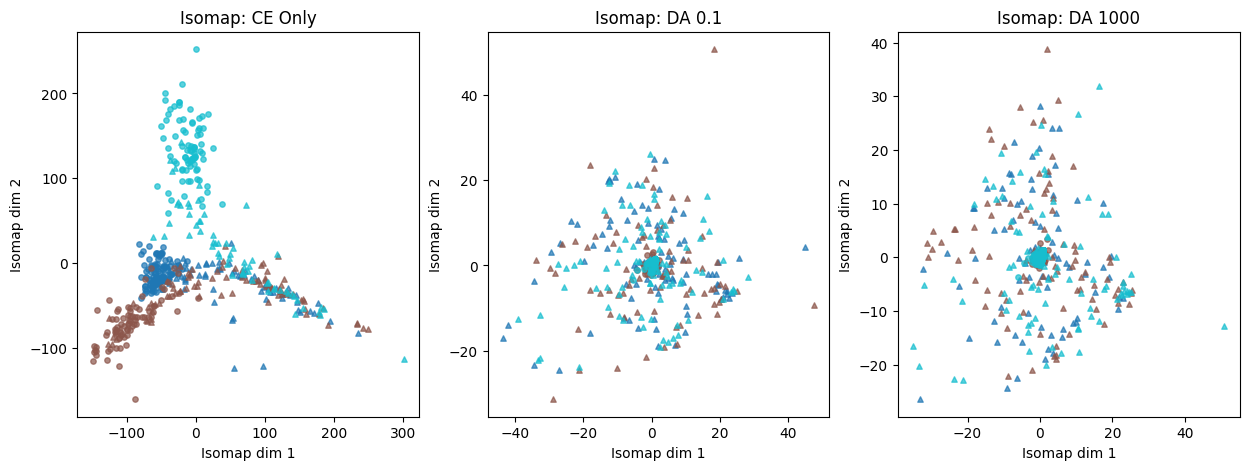

In [14]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler


def extract_latents_with_labels(model, source_loader, target_loader, device):
    model.eval()
    z_all, y_all, domains = [], [], []

    with torch.no_grad():
        for imgs, labels in source_loader:
            imgs = imgs.to(device)
            _, z = model(imgs)
            z_all.append(z.cpu())
            y_all.extend([label_map[int(y)] for y in labels])

            domains.extend(["source"] * len(labels))

        for imgs, labels in target_loader:
            imgs = imgs.to(device)
            _, z = model(imgs)
            z_all.append(z.cpu())
            y_all.extend([label_map[int(y)] for y in labels])

            domains.extend(["target"] * len(labels))

    z_all = torch.cat(z_all, dim=0)
    z_all = torch.tensor(StandardScaler().fit_transform(z_all))
    return z_all, np.array(y_all), np.array(domains)

def plot_isomap_with_colors_and_markers(z_all, y_all, domains, title, xlim=None, ylim=None, subset=500, ax=None, legend=False):

    isomap = Isomap(n_components=2, n_neighbors=20)
    z_2d = isomap.fit_transform(z_all.numpy())

    indices = np.random.choice(len(z_all), size=subset, replace=False)
    z_2d = z_2d[indices]
    y_all = y_all[indices]
    domains = domains[indices]

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    cmap = plt.cm.get_cmap('tab10', 3)

    for digit in range(3):
        color = cmap(digit)
        for domain, marker in zip(["source", "target"], ["o", "^"]):
            idx = (y_all == digit) & (domains == domain)
            ax.scatter(
                z_2d[idx, 0], z_2d[idx, 1],
                label=f"{digit} ({'src' if domain == 'source' else 'tgt'})",
                c=[color], marker=marker, s=15, alpha=0.7
            )

    ax.set_title(title)
    ax.set_xlabel("Isomap dim 1")
    ax.set_ylabel("Isomap dim 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if legend:
        ax.legend(markerscale=1.5, fontsize=9, loc='center left', bbox_to_anchor=(1.02, 0.5))

    if ax is None:
        plt.tight_layout()
        plt.show()




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CE-only model
z_ce, y_ce, d_ce = extract_latents_with_labels(CE_only_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_ce, y_ce, d_ce, "Isomap: CE Only", ax=axes[0], legend=False)

# Sinkhorn-based model (lambda is 0.01)
z_ce, y_ce, d_ce = extract_latents_with_labels(DA_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_ce, y_ce, d_ce, "Isomap: DA 0.1", ax=axes[1], legend=False)

# Sinkhorn-based model (lambda is 1000)
z_da, y_da, d_da = extract_latents_with_labels(DA_model_1000, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_da, y_da, d_da, "Isomap: DA 1000", ax=axes[2], legend=False)


## Trainable weight parameters

The source domain performance dropped further, and the target domain performance is also not that good. Keep in mind that we would not expect a model trained with DA to outperform the source domain. So while we must focus on domain alignment, it shouldn't come at the expense of the primarily learning objective, whether it be classification or regression.

A reasonable guess would then be that $\lambda$ should be less than 1, but it is hard to guess a priori whether it should be $\mathcal{O}(0.1)$, $\mathcal{O}(0.01)$, etc. To be sure, we'd have to sample $\lambda \sim \text{LogUniform}$ and then refine from there, which can be difficult. Even then, that would only apply for this dataset, and not MNIST in Tutorial 1, or any other dataset.

So how can we be certain we're doing things optimally? What one would usually think to do in this case is some sort of search, trying out different values of $\lambda$ within an appropriate range and seeing what works best. But even then, the results could be sensitive to the choice of seed, so you should marginalize over multiple realizations and make it a grid search. But also, we haven't even thought about what to do with $\sigma$, which is important as well, so maybe a cube search...?

I think you see where this is going. There's a lot of things that are important here. Here, I'll talk about a *trainable* way to avoid the $\lambda$ search, using an idea from Bayesian inference. See [this paper](https://arxiv.org/abs/1705.07115).

The overall idea is two introduce trainable coefficients for the two loss terms. Let us introduce two trainable scalar parameters $\eta_1$ and $\eta_2$, and define the following loss function:

$$
\mathcal{L} = \frac{1}{2 \eta_1^2} \mathcal{L}_\text{CE} + \frac{1}{2 \eta_2^2} \mathcal{L}_\text{DA} + \log(|\eta_1 \eta_2|)
$$

These values can then be optimized jointly with the model parameters, avoiding the need for a user-specified weighting for the loss terms.

Let's think about this loss function before proceeding:

* What happens to each loss term as its corresponding $\eta_i \to 0$.
* What does the third term $\log(|\eta_1 \eta_2|)$ do?
* We saw that strongly preffering $\mathcal{L}_\text{DA}$ over $\mathcal{L}_\text{CE}$ will result in bad performance, and that we probably want $\eta_2^{-2} < 2$. This trainable prescription does not know a priori that doing so is bad. Is there any way to enforce this? *Hint*: Think about what range the parameters should be in, initializing them properly and governing their time evolution.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model_eta = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10)
best_model = None
best_loss = float('inf')

## initialize trainable coefficients
eta_1 = nn.Parameter(torch.tensor(0.1, requires_grad=True))
eta_2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

optimizer.add_param_group({"params": [eta_1, eta_2]})

# Training loop
for epoch in tqdm(range(num_epochs)):
    DA_model_eta.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents and outputs
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn(z_s, z_t)
        total_loss = (2 * eta_1**2)**-1 * ce_loss + (2 * eta_2**2)**-1 * DA_loss + torch.log(eta_1 * eta_2)

        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        eta_1.data.clamp_(min=1e-3)
        eta_2.data.clamp_(min=0.25*eta_1.data.item())
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cuda


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/geomloss/utils.py:49: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  D_xy = torch.matmul(x, y.permute(0, 2, 1))  # (B,N,D) @ (B,D,M) = (B,N,M)
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, 

Epoch [1/6], CE Loss: 0.4608, DA Loss: 1.9354 Source Acc: 77.90%, Target Acc: 62.50% eta_1: 0.13837569952011108 eta_2: 1.02110755443573


 33%|███▎      | 2/6 [00:15<00:30,  7.53s/it]

Epoch [2/6], CE Loss: 0.0456, DA Loss: 0.7012 Source Acc: 98.52%, Target Acc: 72.38% eta_1: 0.14080949127674103 eta_2: 1.0073723793029785


 50%|█████     | 3/6 [00:22<00:22,  7.55s/it]

Epoch [3/6], CE Loss: 0.0315, DA Loss: 0.3538 Source Acc: 99.10%, Target Acc: 71.30% eta_1: 0.14170131087303162 eta_2: 0.9659351706504822


 67%|██████▋   | 4/6 [00:29<00:14,  7.39s/it]

Epoch [4/6], CE Loss: 0.0188, DA Loss: 0.2762 Source Acc: 99.32%, Target Acc: 70.86% eta_1: 0.14187772572040558 eta_2: 0.9111462235450745


 83%|████████▎ | 5/6 [00:37<00:07,  7.46s/it]

Epoch [5/6], CE Loss: 0.0130, DA Loss: 0.2049 Source Acc: 99.64%, Target Acc: 70.90% eta_1: 0.14087171852588654 eta_2: 0.8459126353263855


100%|██████████| 6/6 [00:44<00:00,  7.41s/it]

Epoch [6/6], CE Loss: 0.0102, DA Loss: 0.1597 Source Acc: 99.66%, Target Acc: 70.74% eta_1: 0.1393222212791443 eta_2: 0.7714424133300781


In [16]:
DA_model.load_state_dict(best_model)
# Test on source domain (MNIST)
source_accuracy = test_model(DA_model_eta, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(DA_model_eta, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 30.80%
Accuracy on target domain (MNIST-M): 33.50%


In this case you've seen that we've improved both the source and target performance (compared to no-DA), though slightly, without any grid search whatsoever! This trainable prescription largely avoided the need to tune these hyperparameters. Keep in mind we did use some inductive bias: we initialized the $\eta_i$ differently (think as to why we did this), and clipped them in some reasonable way. This was simply to give the parameters a nudge in the right direction.

The last thing we want to study is our treatment of $\sigma$. In the last experiments, we used a fixed value of $\sigma = 10$, but now lets think about the assumption that a single value of $\sigma$ is optimal. It may not be.

Keep in mind that as $\sigma \to 0$ the Sinkhorn plan interpolates closer to $\text{OT}_0$, and $\sigma \to \infty$ interpolates closer to MMD. Further, MMD is cheaper to compute than $\text{OT}_0$ (fewer Sinkhorn iterations), but $\text{OT}_0$ is more accurate. Even then, as $\sigma$ gets smaller that means more Sinkhorn iterations, which can lead to instability (and bias). So how can we optimize computational efficiency and domain alignment accuracy?

Let's now try a simple annealing scheme, so that $\sigma$ is larger at the beginning of training, when the latent spaces are very misaligned, and smaller at the end, when we want to really focus on domain alignment.

Consider the $\sigma$ scheduler given by:

$$
\sigma = 10 * 0.4^\ell \quad \text{where} \; \ell \; \text{is epoch number}
$$

We will test this below.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
DA_model_eta_sigma = CNN().to(device)

num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(DA_model.parameters(), lr=1e-3)
geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=10) # GeomLoss with Sinkhorn distance, p=2, blur ~ σ; tune as needed
best_model = None
best_loss = float('inf')

## initialize trainable coefficients
eta_1 = nn.Parameter(torch.tensor(0.1, requires_grad=True))
eta_2 = nn.Parameter(torch.tensor(1.0, requires_grad=True))

optimizer.add_param_group({"params": [eta_1, eta_2]})

# Training loop
for epoch in tqdm(range(num_epochs)):
    DA_model_eta_sigma.train()
    running_loss, correct_s, correct_t, total_s, total_t = 0.0, 0, 0, 0, 0
    running_DA, running_CE = 0.0, 0.0

    # Loop over source and target datasets
    for (source_imgs, source_labels), (target_imgs, target_labels) in zip(source_train_loader, target_train_loader):
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)
        source_imgs, target_imgs = source_imgs.float(), target_imgs.float()

        source_labels = torch.tensor([label_map[int(l)] for l in source_labels], device=device)
        target_labels = torch.tensor([label_map[int(l)] for l in target_labels], device=device)

        # Forward pass
        combined_imgs = torch.cat([source_imgs, target_imgs], dim=0)
        logits, z = DA_model(combined_imgs)

        # Split latents and outputs
        z_s, z_t = z[:source_imgs.size(0)], z[source_imgs.size(0):]
        logits_s = logits[:source_imgs.size(0)]
        logits_t = logits[source_imgs.size(0):]

        # Dynamic sigma based on epoch
        dynamic_blur = 10 * 0.6**epoch

        # Compute losses
        ce_loss = criterion(logits_s, source_labels)
        DA_loss = geomloss_fn = SamplesLoss("sinkhorn", p=2, blur=dynamic_blur)(z_s, z_t)
        total_loss = (2 * eta_1**2)**-1 * ce_loss + (2 * eta_2**2)**-1 * DA_loss + torch.log(eta_1 * eta_2)

        # Model saving
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model = copy.deepcopy(DA_model.state_dict())

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(DA_model.parameters(), max_norm=10.0)
        eta_1.data.clamp_(min=1e-3)
        eta_2.data.clamp_(min=0.25*eta_1.data.item())
        optimizer.step()

        # Track training stats
        running_loss += total_loss.item()
        running_CE += ce_loss.item()
        running_DA += DA_loss.item()
        _, predicted_s = logits_s.max(1)
        total_s += source_labels.size(0)
        correct_s += predicted_s.eq(source_labels).sum().item()
        _, predicted_t = logits_t.max(1)
        total_t += target_labels.size(0)
        correct_t += predicted_t.eq(target_labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], CE Loss: {running_CE/len(source_train_loader):.4f}, DA Loss: {running_DA/len(source_train_loader):.4f} Source Acc: {100*correct_s/total_s:.2f}%, Target Acc: {100*correct_t/total_t:.2f}%", "eta_1:", eta_1.item(), "eta_2:", eta_2.item())

Using device: cuda


 17%|█▋        | 1/6 [00:07<00:37,  7.40s/it]

Epoch [1/6], CE Loss: 0.0151, DA Loss: 0.1684 Source Acc: 99.54%, Target Acc: 69.82% eta_1: 0.10930006206035614 eta_2: 0.9202188849449158


 33%|███▎      | 2/6 [00:15<00:30,  7.53s/it]

Epoch [2/6], CE Loss: 0.0052, DA Loss: 0.1308 Source Acc: 99.84%, Target Acc: 68.76% eta_1: 0.09464011341333389 eta_2: 0.8357484936714172


 50%|█████     | 3/6 [00:22<00:22,  7.39s/it]

Epoch [3/6], CE Loss: 0.0071, DA Loss: 0.1377 Source Acc: 99.82%, Target Acc: 69.88% eta_1: 0.08831218630075455 eta_2: 0.7514348030090332


 67%|██████▋   | 4/6 [00:29<00:15,  7.51s/it]

Epoch [4/6], CE Loss: 0.0031, DA Loss: 0.0928 Source Acc: 99.90%, Target Acc: 70.08% eta_1: 0.07614228874444962 eta_2: 0.660082221031189


 83%|████████▎ | 5/6 [00:37<00:07,  7.55s/it]

Epoch [5/6], CE Loss: 0.0029, DA Loss: 0.0652 Source Acc: 99.90%, Target Acc: 69.18% eta_1: 0.06197575852274895 eta_2: 0.560427188873291


100%|██████████| 6/6 [00:44<00:00,  7.48s/it]

Epoch [6/6], CE Loss: 0.0099, DA Loss: 0.0597 Source Acc: 99.80%, Target Acc: 67.28% eta_1: 0.08399367332458496 eta_2: 0.4584256410598755


In [18]:
DA_model_eta_sigma.load_state_dict(best_model)
# Test on source domain (MNIST)
source_accuracy = test_model(DA_model_eta_sigma, source_test_loader, device)
print(f"Accuracy on source domain (MNIST): {source_accuracy:.2f}%")

# Test on target domain (MNIST-M)
target_accuracy = test_model(DA_model_eta_sigma, target_test_loader, device)
print(f"Accuracy on target domain (MNIST-M): {target_accuracy:.2f}%")

Accuracy on source domain (MNIST): 99.60%
Accuracy on target domain (MNIST-M): 68.80%


The $\sigma$ scheduler also helps! We can see an increase in the source domain peformance and similar performance in the target domain. There are, of course, numerous options for the time-evolution of $\sigma$ during training. We have shown in [this paper](https://arxiv.org/abs/2501.14048) that a $\sigma$ scheduler based on the 2-norm between latent spaces not only results in better performance on both domains, but is also significantly faster. Try to get creative and come up with your own scheduling for $\sigma$.

---

If you've finished and want to play around with things further, here's some suggestions:

* Track and plot the evolution of the $\eta_i$ throughout training. What can you say about the training dynamics, and how / when $\mathcal{L}_\text{CE}$ and $\mathcal{L}_\text{DA}$ are preffered?
* Compare the performance of the Sinkhorn divergence with $\sigma \to \infty$ with a Gaussian MMD. You can compute both of these within `geomloss`. Which method performs better? Which is faster?
* Visualize the latent space of all these models using isomaps (or UMAP or t-SNE).
* Try implementing the scaling for $\sigma$ as described in Equation 7 [here](https://arxiv.org/pdf/2501.14048). Be creative and think of others! Email me if you find something interesting.

Thus concludes this tutorial. Happy coding!

## Isomaps

Let us now compare the latent spaces of the model without any DA, model with DA we trained with tranable loss weights and model with tranable weights plus a scheduler for sigma which allowes DA to go from more coars (MMD) to Optimal transport (more detailed).

/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)
/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)
/tmp/ipython-input-3262696348.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 3)


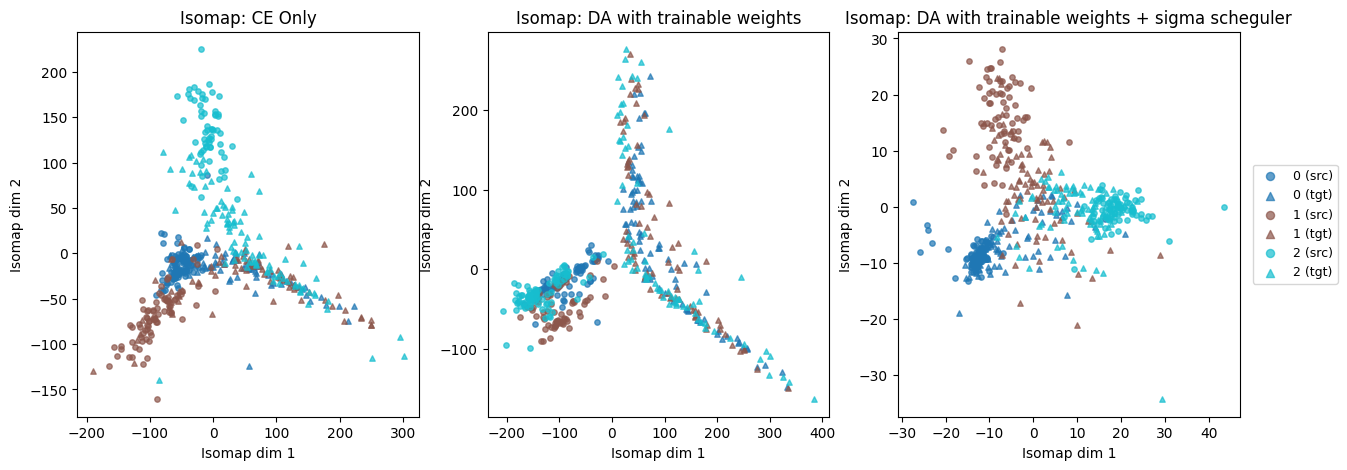

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CE-only model
z_ce, y_ce, d_ce = extract_latents_with_labels(CE_only_model, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_ce, y_ce, d_ce, "Isomap: CE Only", ax=axes[0], legend=False)

# Sinkhorn-based model with trainable weights
z_da, y_da, d_da = extract_latents_with_labels(DA_model_eta, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_da, y_da, d_da, "Isomap: DA with trainable weights", ax=axes[1], legend=False)

# Sinkhorn-based model with trainable weights and sigma scheduler
z_adv, y_adv, d_adv = extract_latents_with_labels(DA_model_eta_sigma, source_test_loader, target_test_loader, device)
plot_isomap_with_colors_and_markers(z_adv, y_adv, d_adv, "Isomap: DA with trainable weights + sigma scheguler", ax=axes[2], legend=True)
